# Settings

In [1]:
EXP_NO = 6
SEED = 1
N_SPLITS = 5
TARGET = 'target'
GROUP = 'art_series_id'
REGRESSION = False

# Library

In [2]:
from collections import defaultdict
from functools import partial
import gc
import glob
import json
from logging import getLogger, StreamHandler, FileHandler, DEBUG, Formatter
import pickle
import os
import sys
import time

import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, mean_squared_error, cohen_kappa_score

SCRIPTS_DIR = os.path.join('..', 'scripts')
assert(os.path.isdir(SCRIPTS_DIR))
if SCRIPTS_DIR not in sys.path: sys.path.append(SCRIPTS_DIR)

from cross_validation import load_cv_object_ids
from dataset import load_csvfiles, load_photofile
from folder import experiment_dir_of
from target import soring_date2target

In [3]:
pd.options.display.float_format = '{:.5f}'.format

# Prepare directory

In [4]:
output_dir = experiment_dir_of(EXP_NO)

In [5]:
output_dir

'..\\scripts\\..\\experiments\\exp006'

# Prepare logger

In [6]:
logger = getLogger(__name__)

In [7]:
'''Refference
https://docs.python.org/ja/3/howto/logging-cookbook.html
'''
logger.setLevel(DEBUG)
# create file handler which logs even debug messages
fh = FileHandler(os.path.join(output_dir, 'log.log'))
fh.setLevel(DEBUG)
# create console handler with a higher log level
ch = StreamHandler()
ch.setLevel(DEBUG)
# create formatter and add it to the handlers
formatter = Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)
len(logger.handlers)

2

In [8]:
logger.info('Experiment no: {}'.format(EXP_NO))
logger.info('CV: StratifiedGroupKFold')
logger.info('SEED: {}'.format(SEED))
logger.info('REGRESSION: {}'.format(REGRESSION))
logger.info('TARGET: {}'.format(TARGET))

2021-07-17 15:09:04,135 - __main__ - INFO - Experiment no: 6
2021-07-17 15:09:04,140 - __main__ - INFO - CV: StratifiedGroupKFold
2021-07-17 15:09:04,141 - __main__ - INFO - SEED: 1
2021-07-17 15:09:04,141 - __main__ - INFO - REGRESSION: False
2021-07-17 15:09:04,142 - __main__ - INFO - TARGET: target


# Load csv files

In [9]:
SINCE = time.time()

In [10]:
logger.debug('Start loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))
train, test, materials, techniques, sample_submission = load_csvfiles()
logger.debug('Complete loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-17 15:09:04,168 - __main__ - DEBUG - Start loading csv files (0.016 seconds passed)
2021-07-17 15:09:04,192 - __main__ - DEBUG - Complete loading csv files (0.040 seconds passed)


In [11]:
train

,object_id,sorting_date,art_series_id,target
0,002bff09b09998d0be65,1631,509357f67692a6a45626,1
1,00309fb1ef05416f9c1f,1900,7987b47bbe5dc3039179,3
2,003a1562e97f79ba96dc,1834,ded7c3c9636708e5b14c,3
3,004890880e8e7431147b,1743,582ac2d7f0cef195b605,2
4,00718c32602425f504c1,1885,64c907f0c08dce4fb8e8,3
...,...,...,...,...
3932,ffa3259fff8e6f3818a1,1850,b187c294b0550acf049a,3
3933,ffd4d361756587883e48,1670,ad49a044770a48f860a6,1
3934,ffd794b7b311b7b7fd92,1789,f030a01b480b18a27be2,2
3935,ffe49bba69d06446de7e,1805,f5287bc84a05aada1d17,3


In [12]:
test

,object_id
0,0009e50b94be36ccad39
1,000bd5e82eb22f199f44
2,0015f44de1854f617516
3,00388a678879ba1efa27
4,005e1e7c6496902d23f3
...,...
5914,ffbe65ad399b632dcbd0
5915,ffd7b2d646c0320c311a
5916,ffdb93ede17d4501e530
5917,ffe111402004b0ed46b4


# Feature engineering

## Extract hog features

In [13]:
%%time
path_train_hog_feature = os.path.join(output_dir, 'train_hog_features.pkl')
if os.path.isfile(path_train_hog_feature):
    with open(train_hog_feature, 'rb') as f:
        train_hog_features = pickle.load(f)
else:
    train_hog_features = {object_id: hog(load_photofile(object_id)) for object_id in train['object_id']}
    with open(path_train_hog_feature, 'wb') as f:
        pickle.dump(train_hog_features, f)

Wall time: 1min 48s


In [14]:
%%time
path_test_hog_feature = os.path.join(output_dir, 'test_hog_features.pkl') 
if os.path.isfile(path_test_hog_feature):
    with open(path_test_hog_feature, 'rb') as f:
        X_test = pickle.load(f)
else:
    X_test = np.array([hog(load_photofile(object_id)) for object_id in test['object_id']])
    with open(path_test_hog_feature, 'wb') as f:
        pickle.dump(X_test, f)

Wall time: 2min 43s


# Cross validation

In [15]:
train.set_index('object_id', inplace=True)

In [16]:
fold_object_ids = load_cv_object_ids()
for i, (train_object_ids, valid_object_ids) in enumerate(zip(fold_object_ids[0], fold_object_ids[1])):
    assert(set(train_object_ids) & set(valid_object_ids) == set())
    num_fold = i + 1
    logger.debug('Start fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))
    # Separate dataset into training/validation fold
    X_train = np.array([train_hog_features[object_id] for object_id in train_object_ids])
    y_train = train.loc[train_object_ids, TARGET].values
    X_valid = np.array([train_hog_features[object_id] for object_id in valid_object_ids])
    y_valid = train.loc[valid_object_ids, TARGET].values
    
    # Training
    logger.debug('Start training model ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## train estimator
    estimator = SVC(C=10.0, random_state=SEED, class_weight='balanced')
    estimator.fit(X_train, y_train)
    logger.debug('Complete training ({:.3f} seconds passed)'.format(time.time() - SINCE))
    
    # Save model and prediction
    ## Prediction
    if REGRESSION:
        pred_train = pd.DataFrame(data=estimator.predict(X_train), columns=['pred'])
        pred_valid = pd.DataFrame(data=estimator.predict(X_valid), columns=['pred'])
        pred_test = pd.DataFrame(data=estimator.predict(X_test), columns=['pred'])
    else:
        try:
            pred_train = pd.DataFrame(data=estimator.predict_proba(X_train),
                                      columns=estimator.classes_)
            pred_valid = pd.DataFrame(data=estimator.predict_proba(X_valid),
                                      columns=estimator.classes_)
            pred_test = pd.DataFrame(data=estimator.predict_proba(X_test),
                                     columns=estimator.classes_)
        except AttributeError:
            pred_train = pd.DataFrame(data=estimator.decision_function(X_train),
                                      columns=estimator.classes_)
            pred_valid = pd.DataFrame(data=estimator.decision_function(X_valid),
                                      columns=estimator.classes_)
            pred_test = pd.DataFrame(data=estimator.decision_function(X_test),
                                     columns=estimator.classes_)
    ## Training set
    pred_train['object_id'] = train_object_ids
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train.to_csv(filepath_fold_train, index=False)
    logger.debug('Save training fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_train, time.time() - SINCE))
    ## Validation set
    pred_valid['object_id'] = valid_object_ids
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid.to_csv(filepath_fold_valid, index=False)
    logger.debug('Save validation fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_valid, time.time() - SINCE))
    ## Test set
    pred_test['object_id'] = test['object_id'].values
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test.to_csv(filepath_fold_test, index=False)
    logger.debug('Save test result {} ({:.3f} seconds passed)' \
                 .format(filepath_fold_test, time.time() - SINCE))
    ## Model
    filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.pkl')
    with open(filepath_fold_model, 'wb') as f:
        pickle.dump(estimator, f)
    logger.debug('Save model {} ({:.3f} seconds passed)'.format(filepath_fold_model, time.time() - SINCE))
    
    # Save memory
    del (estimator, X_train, X_valid, y_train, y_valid, pred_train, pred_valid, pred_test)
    gc.collect()

    logger.debug('Complete fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

2021-07-17 15:13:36,334 - __main__ - DEBUG - Start fold 1 (272.183 seconds passed)
2021-07-17 15:13:36,845 - __main__ - DEBUG - Start training model (272.693 seconds passed)
2021-07-17 15:18:15,481 - __main__ - DEBUG - Complete training (551.329 seconds passed)
2021-07-17 15:45:30,409 - __main__ - DEBUG - Save training fold to ..\scripts\..\experiments\exp006\cv_fold1_training.csv (2186.257 seconds passed)
2021-07-17 15:45:30,418 - __main__ - DEBUG - Save validation fold to ..\scripts\..\experiments\exp006\cv_fold1_validation.csv (2186.266 seconds passed)
2021-07-17 15:45:30,461 - __main__ - DEBUG - Save test result ..\scripts\..\experiments\exp006\cv_fold1_test.csv (2186.309 seconds passed)
2021-07-17 15:45:32,300 - __main__ - DEBUG - Save model ..\scripts\..\experiments\exp006\cv_fold1_model.pkl (2188.149 seconds passed)
2021-07-17 15:45:32,737 - __main__ - DEBUG - Complete fold 1 (2188.585 seconds passed)
2021-07-17 15:45:32,738 - __main__ - DEBUG - Start fold 2 (2188.586 seconds pa

# Evaluation

In [17]:
rmse = partial(mean_squared_error, squared=False)

In [18]:
# qwk = partial(cohen_kappa_score, labels=np.sort(train['target'].unique()), weights='quadratic')

In [19]:
@np.vectorize
def predict(proba_0: float, proba_1: float, proba_2: float, proba_3: float) -> int:
    return np.argmax((proba_0, proba_1, proba_2, proba_3))

In [20]:
metrics = defaultdict(list)

## Training set

In [21]:
pred_train_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (training set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train_df = pd.read_csv(filepath_fold_train)
    if REGRESSION:
        if TARGET == 'target':
            pred_train_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_train_df['pred'] = np.vectorize(soring_date2target)(pred_train_df['pred'])
    else:
        pred_train_df['pred'] = predict(pred_train_df['0'], pred_train_df['1'],
                                        pred_train_df['2'], pred_train_df['3'])
    pred_train_df['actual'] = train.loc[pred_train_df['object_id'], TARGET].values
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_train_df['actual'], pred_train_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_train_df['actual'], pred_train_df['pred'])
#     score = qwk(pred_train_df['actual'], pred_train_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['train_losses'].append(loss)
#     metrics['train_scores'].append(score)
    pred_train_dfs.append(pred_train_df)

metrics['train_losses_avg'] = np.mean(metrics['train_losses'])
metrics['train_losses_std'] = np.std(metrics['train_losses'])
# metrics['train_scores_avg'] = np.mean(metrics['train_scores'])
# metrics['train_scores_std'] = np.std(metrics['train_scores'])

2021-07-17 17:59:54,521 - __main__ - DEBUG - Evaluate cv result (training set) Fold 1
2021-07-17 17:59:54,719 - __main__ - DEBUG - Loss: 0.0
2021-07-17 17:59:54,719 - __main__ - DEBUG - Evaluate cv result (training set) Fold 2
2021-07-17 17:59:54,763 - __main__ - DEBUG - Loss: 0.0
2021-07-17 17:59:54,764 - __main__ - DEBUG - Evaluate cv result (training set) Fold 3
2021-07-17 17:59:54,803 - __main__ - DEBUG - Loss: 0.0
2021-07-17 17:59:54,804 - __main__ - DEBUG - Evaluate cv result (training set) Fold 4
2021-07-17 17:59:54,845 - __main__ - DEBUG - Loss: 0.0
2021-07-17 17:59:54,846 - __main__ - DEBUG - Evaluate cv result (training set) Fold 5
2021-07-17 17:59:54,883 - __main__ - DEBUG - Loss: 0.0


[[ 369    0    0    0]
 [   0  714    0    0]
 [   0    0 1206    0]
 [   0    0    0  851]]
[[ 384    0    0    0]
 [   0  715    0    0]
 [   0    0 1215    0]
 [   0    0    0  847]]
[[ 378    0    0    0]
 [   0  707    0    0]
 [   0    0 1201    0]
 [   0    0    0  861]]
[[ 382    0    0    0]
 [   0  713    0    0]
 [   0    0 1237    0]
 [   0    0    0  820]]
[[ 387    0    0    0]
 [   0  735    0    0]
 [   0    0 1185    0]
 [   0    0    0  841]]


In [22]:
pred_train = pd.concat(pred_train_dfs).groupby('object_id').sum()
pred_train = pred_train / N_SPLITS
if not REGRESSION:
    pred_train['pred'] = predict(pred_train['0'], pred_train['1'], pred_train['2'], pred_train['3'])
pred_train['actual'] = train.loc[pred_train.index, TARGET].values
pred_train

,0,1,2,3,pred,actual
object_id,,,,,,
002bff09b09998d0be65,0.03369,2.60000,1.61774,0.44472,1,1
00309fb1ef05416f9c1f,-0.18927,1.61088,0.70125,2.60000,3,3
003a1562e97f79ba96dc,-0.19503,0.68164,1.68027,2.60136,3,3
004890880e8e7431147b,-0.17619,1.11294,2.60192,1.10268,2,2
00718c32602425f504c1,-0.19298,0.69355,1.65538,2.60059,3,3
...,...,...,...,...,...,...
ffa3259fff8e6f3818a1,-0.18995,0.70772,1.60444,2.60000,3,3
ffd4d361756587883e48,0.45926,2.60000,1.59805,0.02685,1,1
ffd794b7b311b7b7fd92,-0.18839,0.69967,2.60000,1.60235,2,2


In [23]:
if not (REGRESSION and TARGET == 'target'):
    print(confusion_matrix(pred_train['actual'], pred_train['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_train['actual'], pred_train['pred'])
# score = qwk(pred_train['actual'], pred_train['pred'])
metrics['train_loss'] = loss
# metrics['train_score'] = score
logger.info('Training loss: {}'.format(loss))
# logger.info('Training score: {}'.format(score))

2021-07-17 17:59:54,982 - __main__ - INFO - Training loss: 0.0


[[ 475    0    0    0]
 [   0  896    0    0]
 [   0    0 1511    0]
 [   0    0    0 1055]]


In [24]:
pred_train.to_csv(os.path.join(output_dir, 'prediction_train.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_train.csv')))

2021-07-17 17:59:55,021 - __main__ - DEBUG - Write cv result to ..\scripts\..\experiments\exp006\prediction_train.csv


## Validation set

In [25]:
pred_valid_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (validation set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid_df = pd.read_csv(filepath_fold_valid)
    if REGRESSION:
        if TARGET == 'target':
            pred_valid_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_valid_df['pred'] = np.vectorize(soring_date2target)(pred_valid_df['pred'])
    else:
        pred_valid_df['pred'] = predict(pred_valid_df['0'], pred_valid_df['1'],
                                        pred_valid_df['2'], pred_valid_df['3'])        
    pred_valid_df['actual'] = train.loc[pred_valid_df['object_id'], TARGET].values
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_valid_df['actual'], pred_valid_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_valid_df['actual'], pred_valid_df['pred'])
#     score = qwk(pred_valid_df['actual'], pred_valid_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['valid_losses'].append(loss)
#     metrics['valid_scores'].append(score)
    pred_valid_dfs.append(pred_valid_df)
    
metrics['valid_losses_avg'] = np.mean(metrics['valid_losses'])
metrics['valid_losses_std'] = np.std(metrics['valid_losses'])
# metrics['valid_scores_avg'] = np.mean(metrics['valid_scores'])
# metrics['valid_scores_std'] = np.std(metrics['valid_scores'])

2021-07-17 17:59:55,045 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 1
2021-07-17 17:59:55,070 - __main__ - DEBUG - Loss: 1.0043818676230856
2021-07-17 17:59:55,071 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 2
2021-07-17 17:59:55,095 - __main__ - DEBUG - Loss: 1.024191911784578
2021-07-17 17:59:55,095 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 3
2021-07-17 17:59:55,116 - __main__ - DEBUG - Loss: 1.0896521335508405
2021-07-17 17:59:55,117 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 4
2021-07-17 17:59:55,137 - __main__ - DEBUG - Loss: 1.0282630211985313
2021-07-17 17:59:55,138 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 5
2021-07-17 17:59:55,155 - __main__ - DEBUG - Loss: 1.0150951930486964


[[ 25  33  37  11]
 [  8  59  91  24]
 [  4  48 208  45]
 [  6  23  74 101]]
[[ 20  22  36  13]
 [ 13  59  76  33]
 [  5  38 214  39]
 [  7  15  90  96]]
[[ 18  27  33  19]
 [ 13  55  90  31]
 [ 11  44 187  68]
 [  5  27  72  90]]
[[ 21  27  32  13]
 [ 12  61  83  27]
 [  3  32 199  40]
 [  6  30  97 102]]
[[ 16  26  37   9]
 [ 14  41  77  29]
 [  8  32 224  62]
 [  5  25  80 104]]


In [26]:
pred_valid = pd.concat(pred_valid_dfs).groupby('object_id').sum()
pred_valid = pred_valid / N_SPLITS
if not REGRESSION:
    pred_valid['pred'] = predict(pred_valid['0'], pred_valid['1'], pred_valid['2'], pred_valid['3'])
pred_valid['actual'] = train.loc[pred_valid.index, TARGET].values
pred_valid

,0,1,2,3,pred,actual
object_id,,,,,,
002bff09b09998d0be65,-0.03695,0.42910,0.63580,0.17274,2,1
00309fb1ef05416f9c1f,-0.04322,0.64402,0.42690,0.17085,1,3
003a1562e97f79ba96dc,-0.04961,0.17688,0.43846,0.64500,3,3
004890880e8e7431147b,-0.04325,0.38696,0.65056,0.16588,2,2
00718c32602425f504c1,-0.04753,0.18692,0.43499,0.64124,3,3
...,...,...,...,...,...,...
ffa3259fff8e6f3818a1,-0.04652,0.22365,0.41747,0.63894,3,3
ffd4d361756587883e48,0.18006,0.63948,0.43096,-0.04362,1,1
ffd794b7b311b7b7fd92,-0.04660,0.21928,0.63456,0.43042,2,2


In [27]:
if not REGRESSION:
    print(confusion_matrix(pred_valid['actual'], pred_valid['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_valid['actual'], pred_valid['pred'])
# score = qwk(pred_valid['actual'], pred_valid['pred'])
metrics['valid_loss'] = loss
# metrics['valid_score'] = score
logger.info('Validatino loss: {}'.format(loss))
# logger.info('Validatino score: {}'.format(score))

2021-07-17 17:59:55,219 - __main__ - INFO - Validatino loss: 1.032738172576315


[[ 100  135  175   65]
 [  60  275  417  144]
 [  31  194 1032  254]
 [  29  120  413  493]]


In [28]:
pred_valid.to_csv(os.path.join(output_dir, 'prediction_valid.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_valid.csv')))

2021-07-17 17:59:55,260 - __main__ - DEBUG - Write cv result to ..\scripts\..\experiments\exp006\prediction_valid.csv


In [29]:
with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(dict(metrics), f)
logger.debug('Write metrics to {}'.format(os.path.join(output_dir, 'metrics.json')))

2021-07-17 17:59:55,280 - __main__ - DEBUG - Write metrics to ..\scripts\..\experiments\exp006\metrics.json


# Prediction

In [30]:
pred_test_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test_df = pd.read_csv(filepath_fold_test)
    pred_test_dfs.append(pred_test_df)

In [31]:
pred_test = pd.concat(pred_test_dfs).groupby('object_id').sum()
pred_test = pred_test / N_SPLITS
if REGRESSION:
    if TARGET == 'target':
        pred_test['pred'].clip(lower=0, upper=3, inplace=True)
    else:
        pred_test['pred'] = np.vectorize(soring_date2target)(pred_test['pred'])
else:
    pred_test['pred'] = predict(pred_test['0'], pred_test['1'], pred_test['2'], pred_test['3'])
pred_test

,0,1,2,3,pred
object_id,,,,,
0009e50b94be36ccad39,0.33929,2.66176,1.61529,1.37196,1
000bd5e82eb22f199f44,1.58477,0.76112,3.11425,0.51929,2
0015f44de1854f617516,-0.18302,1.78841,3.20801,1.11904,2
00388a678879ba1efa27,-0.14819,1.18337,2.69366,2.29427,2
005e1e7c6496902d23f3,0.95287,2.55268,2.75342,-0.20172,2
...,...,...,...,...,...
ffbe65ad399b632dcbd0,-0.24847,0.89331,2.17867,3.22996,3
ffd7b2d646c0320c311a,-0.22240,2.15956,3.23876,0.80319,2
ffdb93ede17d4501e530,-0.21637,1.27766,2.73935,2.33755,2


In [32]:
test['target'] = pred_test.loc[test['object_id'], 'pred'].values
test = test[['target']]
test

,target
0,1
1,2
2,2
3,2
4,2
...,...
5914,3
5915,2
5916,2
5917,2


In [33]:
sample_submission

,target
0,3
1,1
2,3
3,3
4,0
...,...
5914,2
5915,1
5916,1
5917,3


In [34]:
test.to_csv(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv'), index=False)
logger.debug('Write submission to {}'.format(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv')))

2021-07-17 17:59:55,553 - __main__ - DEBUG - Write submission to ..\scripts\..\experiments\exp006\006_submission.csv


2021-07-17 17:59:55,649 - __main__ - DEBUG - Write figure to ..\scripts\..\experiments\exp006\prediction.png


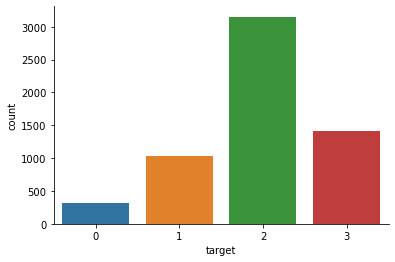

In [35]:
fig = plt.figure()
if not (REGRESSION and TARGET == 'target'):
    sns.countplot(data=test, x='target')
else:
    sns.histplot(data=test, x='target')
sns.despine()
fig.savefig(os.path.join(output_dir, 'prediction.png'))
logger.debug('Write figure to {}'.format(os.path.join(output_dir, 'prediction.png')))

In [36]:
logger.debug('Complete ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-17 17:59:55,732 - __main__ - DEBUG - Complete (10251.580 seconds passed)
